In [45]:
import pickle
import numpy as np
import os
import torch
import torch.nn as nn
import re
import sys
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)

from sr_model.models.models import AnalyticSR, STDP_SR, Linear, MLP
from datasets import inputs, sf_inputs_discrete
from run_td_rnn import run as run_rnn
from run_td_mlp import run as run_mlp
from run_td_linear import run as run_linear

device = 'cpu'

# Specify dataset and run network

In [46]:
num_states = 10*10

In [47]:
# One hot
feature_maker_kwargs = {
    'feature_dim': num_states, 'feature_type': 'nhot'
    }

# # Correlated inputs
# feature_maker_kwargs = {
#     'feature_dim': num_states, 'feature_vals': None,
#     'feature_vals_p': [0.8, 0.2],
#     'feature_type': 'correlated_distributed',
#     'spatial_sigma': 1.5
#     }

# Barrier locations

dataset_config = {
    'num_steps': 4000, 'num_states': num_states,
    'feature_maker_kwargs': feature_maker_kwargs,
    'barriers': 'transitions'
    }
dataset = sf_inputs_discrete.Sim2DWalk

input_size = feature_maker_kwargs['feature_dim']

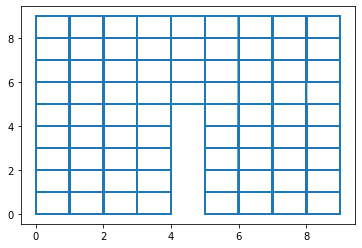

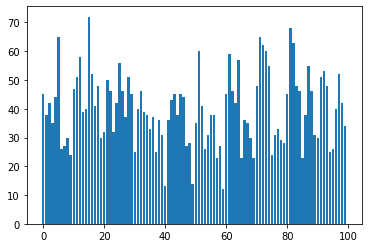

39.5


0.0

In [48]:
input = dataset(**dataset_config)
plt.figure();
plt.plot(input.xs, input.ys)
plt.show()

plt.figure();
states = np.argwhere(input.state_inputs)[:,0]
counts = np.zeros(input.num_states)
for state in np.arange(input.num_states):
    counts[state] = np.sum(states==state)
plt.bar(np.arange(input.num_states), counts)
plt.show()
print(np.median(counts))
np.sum(counts == 0)/input.num_states

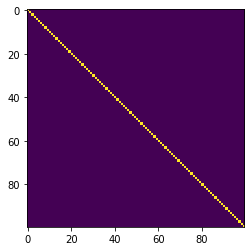

In [49]:
plt.figure()
plt.imshow(input.feature_maker.feature_map)
plt.show()

In [50]:
gamma=0.7

In [51]:
arena_length = int(np.sqrt(input.num_states)) - 1
walk_xs = input.xs.astype(int)
walk_ys = input.ys.astype(int)

In [52]:
rnn = AnalyticSR(
    num_states=input_size, gamma=gamma,
    ca3_kwargs={
        'use_dynamic_lr':False, 'lr': 1E-3,
        #'parameterize': True,
        #'alpha': 1.2, 'beta': 1.2
        }
    )
outputs, loss, dset = run_rnn(
    '../trained_models/test/', rnn, dataset,
    dataset_config, gamma=gamma, test_over_all=False,
    train_net=False, return_dset=True
    )


[   51] loss: 0.005
Time per step 0.032s, net 1.583s

[  101] loss: 0.005
Time per step 0.040s, net 3.567s

[  151] loss: 0.005
Time per step 0.042s, net 5.663s

[  201] loss: 0.005
Time per step 0.047s, net 7.991s

[  251] loss: 0.005
Time per step 0.050s, net 10.486s

[  301] loss: 0.005
Time per step 0.052s, net 13.100s

[  351] loss: 0.005
Time per step 0.051s, net 15.630s

[  401] loss: 0.005
Time per step 0.058s, net 18.521s

[  451] loss: 0.005
Time per step 0.051s, net 21.068s

[  501] loss: 0.005
Time per step 0.060s, net 24.048s

[  551] loss: 0.005
Time per step 0.078s, net 27.929s

[  601] loss: 0.005
Time per step 0.065s, net 31.196s

[  651] loss: 0.005
Time per step 0.061s, net 34.225s

[  701] loss: 0.005
Time per step 0.049s, net 36.691s

[  751] loss: 0.005
Time per step 0.066s, net 40.005s

[  801] loss: 0.005
Time per step 0.061s, net 43.068s

[  851] loss: 0.005
Time per step 0.063s, net 46.225s

[  901] loss: 0.005
Time per step 0.072s, net 49.826s

[  951] loss:

In [53]:
walk_xs = dset.xs
walk_ys = dset.ys
arena_length = int(np.sqrt(dset.num_states))

# Make Plots

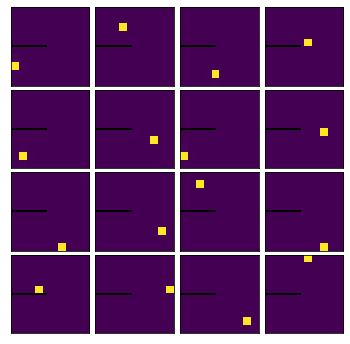

In [54]:
import matplotlib.gridspec as gridspec

grid_x = 4; grid_y = 4;

plt.figure(figsize = (6, 6))
gs1 = gridspec.GridSpec(grid_x, grid_y)
gs1.update(wspace=0.05, hspace=0.05) # set the spacing between axes. 

neurs = np.arange(outputs.shape[1])
np.random.shuffle(neurs)

idx = 0
for neur in neurs:
    firing_field = np.zeros((arena_length, arena_length))*np.nan
    for x in range(arena_length):
        for y in range(arena_length):
            frame_idxs = np.logical_and(walk_xs == x, walk_ys == y)
            fr = np.nanmean(outputs[frame_idxs, neur])
            firing_field[x,y] = fr
    firing_field[np.isnan(firing_field)] = 0    
    if not np.any(firing_field > 0): continue
    ax = plt.subplot(gs1[idx])
    plt.axis('on')
    ax.imshow(firing_field/firing_field.max(), vmin=0, vmax=1)
    ax.plot([-0.5, 4.], [4.5, 4.5], 'black', linewidth=2)
    ax.set_xticks([])
    ax.set_yticks([])
    
    idx += 1
    if idx == grid_x*grid_y: break
plt.show()